# Session 2: General pipeline for machine learning

In this session we will build a general pipeline for machine learning using scikit-learn and pandas for preprocessing and feature engineering.

In [7]:
# import initial modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## General pipeline

Consider this a general guide for using Machine Learning to build predictions or recommendations. For every use case there will be parts that might differ, but you can follow this as an initial approach.

Steps:

0. Understanding the problem, the requirements and the goal
1. Data collection
2. Data cleaning
3. Feature engineering
4. Model training
5. Model evaluation

After evaluating our model, there are more steps like visualization, storytelling, reporting, model deployment, model monitoring, etc. These are not covered in this session.


## 0. Understanding the problem, the requirements and the goal

Our problem is that the price of electricity in the wholesale market is subject to a high volatility, therefore by having solid predictions of it, we can control our risk and hedge against it.

The requirements are that we need to provide a prediction as a 24h prediction of this price for every day in a timely manner and with some degree of accuracy.

Our goal, obviously is to obtain a model that can predict the price of electricity in the wholesale market.

## 1. Data collection: reading the data and understanding the goal

In real life, the data is not in a CSV file, but it's rather in a database, in a directory in a bunch of files, in a streaming pipeline, etc. In this session we will use a CSV file as an example.

The data we're going to use is the `energy` dataset that we've used in the past, and our goal is to create a Machine Learning model that predicts the spot price of electricity in Spain given some power market variables.

With this approach, we will train an algorithm to learn the relationship between the variables (x) and the target variable (`spot_price`, y).

In [26]:
energy = pd.read_csv("../datasets/energy.csv")

energy.head()

,datetime,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,month,day,hour,weekday
0,2018-12-31 23:00:00+00:00,23251.2,6059.2,2954.0,7.1,3202.8,1867.0,3830.3,66.88,2018,12,31,23,0
1,2019-01-01 00:00:00+00:00,22485.0,6059.2,3044.1,8.0,2884.4,1618.0,3172.1,66.88,2019,1,1,0,1
2,2019-01-01 01:00:00+00:00,20977.0,6059.2,3138.6,7.5,1950.8,1535.3,2980.5,66.00,2019,1,1,1,1
3,2019-01-01 02:00:00+00:00,19754.2,6059.2,3596.2,7.5,1675.7,1344.0,2840.0,63.64,2019,1,1,2,1
4,2019-01-01 03:00:00+00:00,19320.6,6063.4,3192.6,7.5,1581.8,1345.0,3253.4,58.85,2019,1,1,3,1


Now that we have our data as a DataFrame, we can use all the data analysis techniques we know to understand the problem.

## 2. Data cleaning: preparing the data and analyze it.

Things to keep in mind when working in Machine Learning:
* The distribution of the data is important, both x and y
    * Are there any outlier values? what should we do with them?
    * Should we normalize the data?
    * Should we standardize the data?
* Do we have categorical features? Should we encode them?
* The dates should be in a format that can be parsed by pandas, but not passed to our algorithm
* We need a strategy for NaN/missing values


In [27]:
# convert date column to datetime
energy["datetime"] = pd.to_datetime(energy["datetime"])

Now that we have our data in a DataFrame, we can use all the data analysis techniques we know to understand the problem.

Let's assess the distribution of the data. I'm going to use Seaborn to do this.

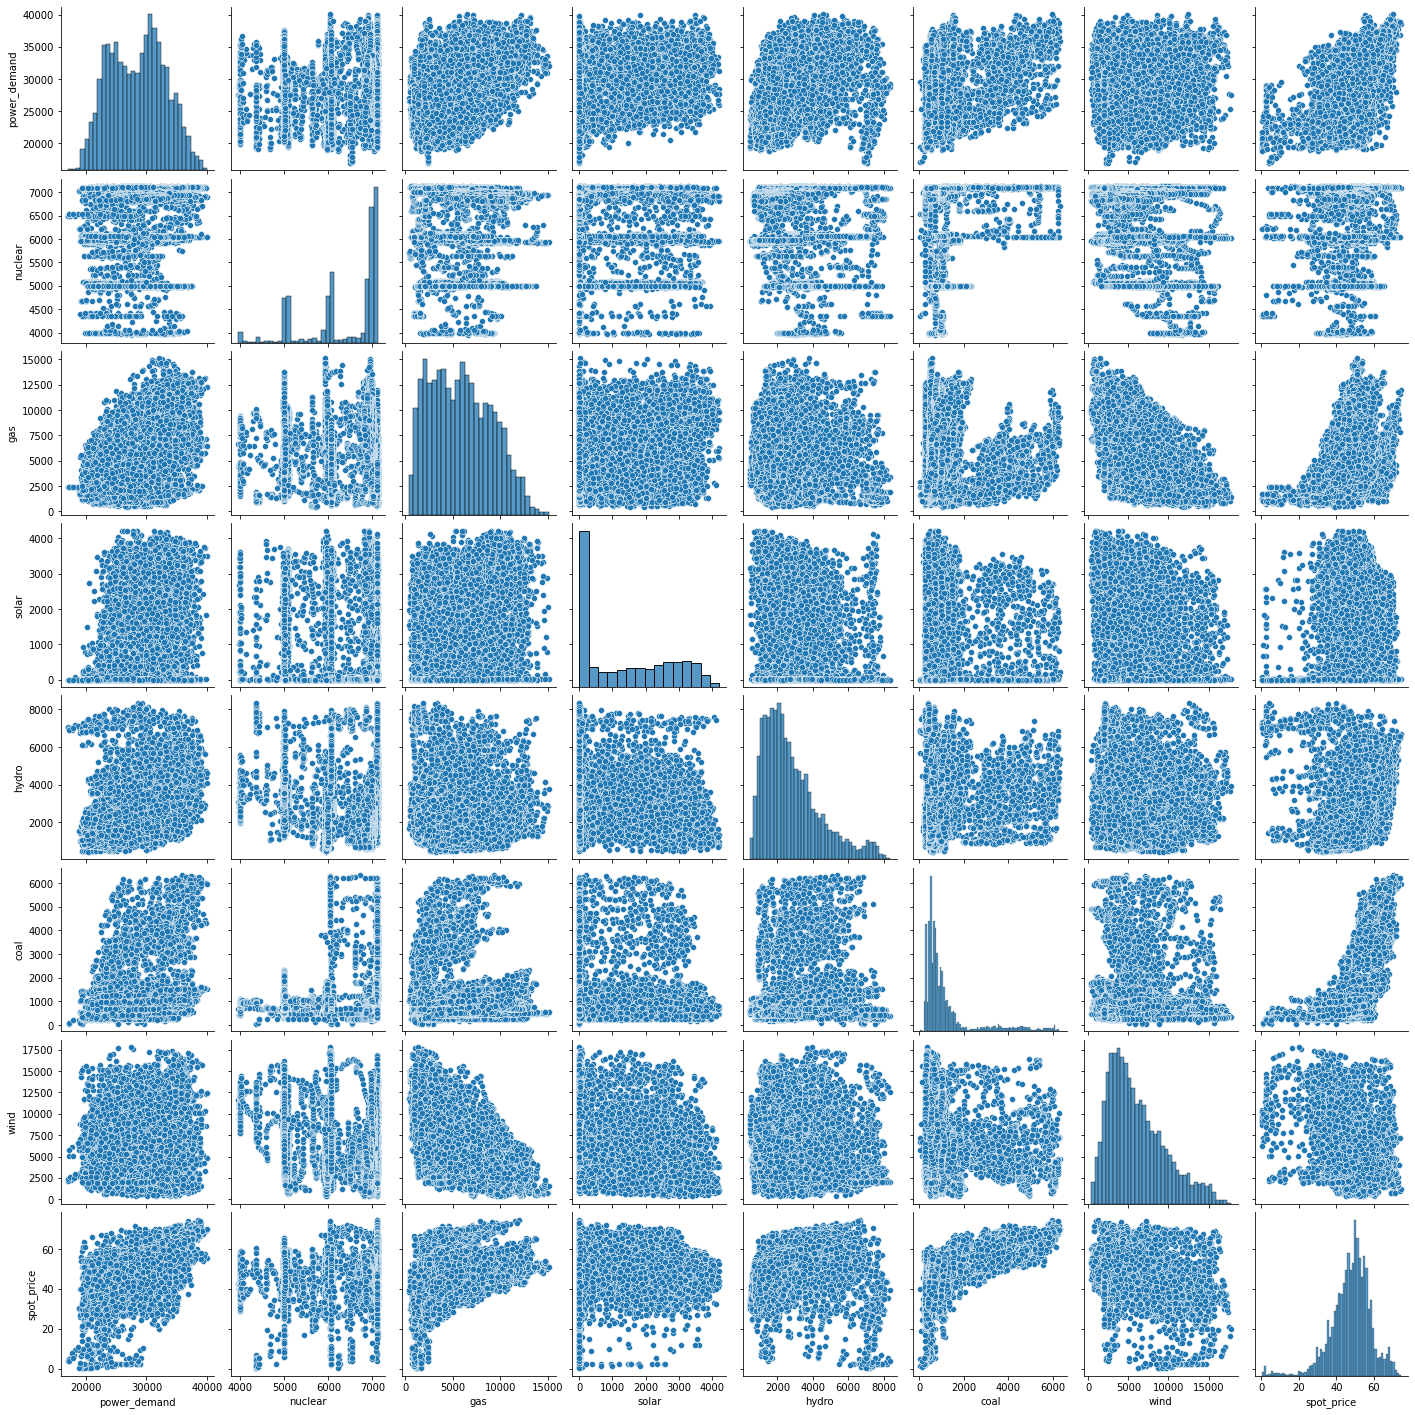

In [28]:
# checking distributions of data
cols_for_distrib = [
    "power_demand",	"nuclear", "gas", "solar", "hydro",	"coal",	"wind",	"spot_price"
]
sns.pairplot(energy[cols_for_distrib])

We see that there are some features that are not normally distributed, like the `wind` and `solar`.

Also, `nuclear` looks binned, which sounds like a categorical feature. 

In general there's some skew in our variables that we can deal with. 

In [29]:
# nan/missing values

energy.isna().mean()

datetime        0.000000
power_demand    0.000000
nuclear         0.000000
gas             0.000000
solar           0.273778
hydro           0.000000
coal            0.017054
wind            0.000000
spot_price      0.000000
year            0.000000
month           0.000000
day             0.000000
hour            0.000000
weekday         0.000000
dtype: float64

We see some NaN in `solar` and `coal`. Let's dig deeper.

In [30]:
# analyze NaN in `solar`

energy[
    (energy["solar"].isna())
]["hour"].unique()

array([23,  0,  1,  2,  3,  4, 19, 20, 21, 22, 18,  5])

In [31]:
# analyze NaN in `coal`

energy[
    (energy["coal"].isna())
]["hour"].unique()

array([23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22])

For solar it's clear: it's at nighttime. For coal, though, it's not so clear. The point, luckily, is that we can consider there's no power generation with those technologies, and therefore use 0 to fill NaN!

In [32]:
energy.fillna(0, inplace=True)

## 3. Feature engineering: creating new features and cleaning the data

In this stage, we will create new information based in what we've found in the data analysis and cleaning. It's crucial in this stage to also include the domain knowledge we have. If we don't have that knowledge, ask your colleagues, ask your boss, ask your friends, or read. It's the domain knowledge that we need to make our model work well.

### 3.1. Dealing with nuclear feature:

We saw some bins, let's create categories out of them.

We know that, in Spain, the nuclear reactors average 1000 MW of power, so we can guess how many nuclear reactors are available at each hour by dividing by 1000 and keeping the integer part.

In [33]:
energy["nuclear_available"] = energy["nuclear"].map(lambda x: int(x/1000))

### 3.2. Creating new features

* Using domain knowledge: `thermal_gap`
* Using lags and rolling windows to convert a timeseries problem into a supervised learning problem

In [34]:
energy["thermal_gap"] = (
    energy["power_demand"] - 
    energy["nuclear"] -
    energy["wind"] - 
    energy["solar"]
)

In [35]:
# let's check correlations
energy.corr()[["spot_price"]].sort_values("spot_price")

,spot_price
month,-0.526890
wind,-0.354866
weekday,-0.192503
year,-0.018852
day,-0.018006
solar,0.053682
hydro,0.070018
nuclear,0.191179
hour,0.207413
nuclear_available,0.253885


In [36]:
lags = [1, 2, 6]
windows = [2, 6, 12]
cols_feat_eng = [
    "power_demand",	"nuclear", "gas", "solar", "hydro",	"coal",	"wind"
]

# lags of features
for col in cols_feat_eng:
    for lag in lags:
        energy[f"{col}_lag{lag}"] = energy[col].shift(lag)
    for window in windows:
        energy[f"{col}_mean{window}"] = energy[col].rolling(window).mean()
        
energy.head()

,datetime,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,...,coal_lag6,coal_mean2,coal_mean6,coal_mean12,wind_lag1,wind_lag2,wind_lag6,wind_mean2,wind_mean6,wind_mean12
0,2018-12-31 23:00:00+00:00,23251.2,6059.2,2954.0,7.1,3202.8,1867.0,3830.3,66.88,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 00:00:00+00:00,22485.0,6059.2,3044.1,8.0,2884.4,1618.0,3172.1,66.88,2019,...,NaN,1742.50,NaN,NaN,3830.3,NaN,NaN,3501.20,NaN,NaN
2,2019-01-01 01:00:00+00:00,20977.0,6059.2,3138.6,7.5,1950.8,1535.3,2980.5,66.00,2019,...,NaN,1576.65,NaN,NaN,3172.1,3830.3,NaN,3076.30,NaN,NaN
3,2019-01-01 02:00:00+00:00,19754.2,6059.2,3596.2,7.5,1675.7,1344.0,2840.0,63.64,2019,...,NaN,1439.65,NaN,NaN,2980.5,3172.1,NaN,2910.25,NaN,NaN
4,2019-01-01 03:00:00+00:00,19320.6,6063.4,3192.6,7.5,1581.8,1345.0,3253.4,58.85,2019,...,NaN,1344.50,NaN,NaN,2840.0,2980.5,NaN,3046.70,NaN,NaN


In [37]:
energy.corr()[["spot_price"]].sort_values("spot_price")

,spot_price
month,-0.526890
wind_mean6,-0.358318
wind_lag2,-0.357360
wind_lag1,-0.357187
wind_mean2,-0.356428
wind,-0.354866
wind_mean12,-0.352124
wind_lag6,-0.345837
weekday,-0.192503
hydro_lag6,-0.185867


In [40]:
# shape of dataset
energy.shape

(8737, 58)

In [42]:
# drop NaN values from feature engineering
energy.dropna(inplace=True)

## 4. Model training: training the model

Let's start with the fun part (~5% of data science): machine learning.

For this problem, I'll use a Random Forest Regressor.
* A Random Forest Regressor is a model that uses a collection of decision trees to make predictions.
* Good performance and good accuracy
* Prone to overfitting 
* Very good explainability


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [45]:
# lets prepare the data for splitting: x and y
# x: features, y: target

x = energy.drop([
    "datetime", "spot_price"
], axis=1)

y = energy["spot_price"]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2,
    random_state=42
)

In [50]:
# intialize model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# train the model
rf.fit(x_train, y_train)

# create prediction
y_hat = rf.predict(x_test)

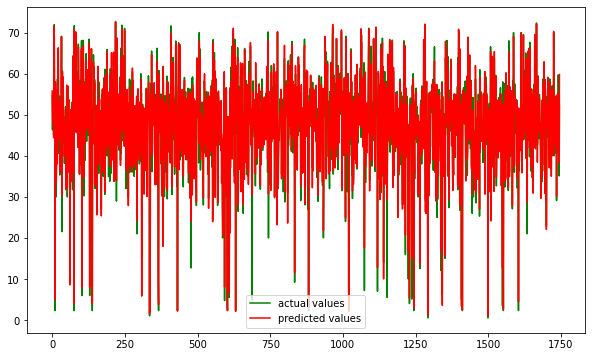

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_test.values, label="actual values", c="green")
ax.plot(y_hat, label="predicted values", c="red")
ax.legend()

## 5. Model Evaluation

Now we've created a prediction model, we can evaluate it. We can do this by comparing the predictions (`y_hat`) with the actual values (`y_test`).

In [54]:
# how good is the model?

# assess the model's performance by using MSE: mean squared error
# MSE = mean( (y_hat - y_test)^2 )

mse = mean_squared_error(y_test, y_hat)

print(mse)

5.814938774169532


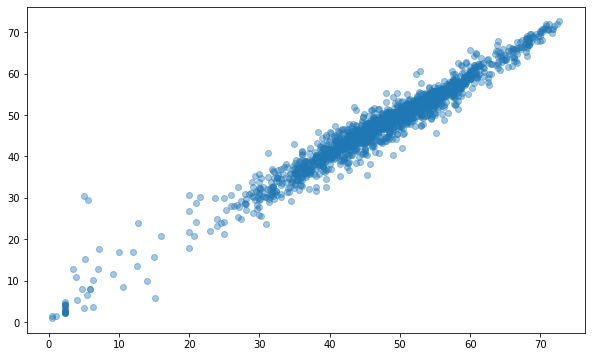

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test.values, y_hat, alpha=0.4)

We can see that the model doesn't have a perfect fit, but it's still a good fit.

At this point, in order to improve the performance, we have several options, not mutually exclusive:
* Get more data
* Get better data
* Get more domain knowledge
* Fine tune the algorithm
* Control underfitting / overfitting